# Create Dummy Data


In [1]:
# JUPYTER CELL — Stage 1: Generate consecutive OHLCV data
import numpy as np
import pandas as pd

def make_consecutive_ohlcv(
    periods=5000,
    start="2022-01-03 09:30",
    freq="5min",
    start_price=100000.0,
    drift_per_bar=0.005,   # mean log-return per bar (upward drift)
    vol_per_bar=0.02,       # std of log-returns per bar (volatility)
    wick_frac=0.5,          # wick size factor relative to body/volatility
    vol_min=100, vol_max=5000,
    seed=2025
) -> pd.DataFrame:
    """Generate a consecutive OHLCV DataFrame where open[t] == close[t-1]."""
    rng = np.random.default_rng(seed)

    # Time index
    idx = pd.date_range(start, periods=periods, freq=freq)

    # Price path via log-returns ~ N(drift, vol)
    rets = rng.normal(loc=drift_per_bar, scale=vol_per_bar, size=periods)
    close = start_price * np.exp(np.cumsum(rets))

    # Consecutive opens
    open_ = np.empty(periods, dtype=float)
    open_[0] = start_price
    open_[1:] = close[:-1]

    # Wicks based on body and volatility
    body = np.abs(close - open_)
    wick_scale = wick_frac * (body + (vol_per_bar * 0.5 * close))
    up_wick = rng.random(periods) * wick_scale
    dn_wick = rng.random(periods) * wick_scale

    high = np.maximum(open_, close) + up_wick
    low  = np.minimum(open_, close) - dn_wick
    low = np.clip(low, 1e-9, None)  # keep prices positive

    # Integer volumes
    volume = rng.integers(low=vol_min, high=vol_max, size=periods)

    df = pd.DataFrame(
        {"open": open_, "high": high, "low": low, "close": close, "volume": volume},
        index=idx
    ).rename(columns=str.lower).sort_index()

    # Sanity: ensure consecutiveness
    assert np.allclose(df["open"].iloc[1:].values, df["close"].iloc[:-1].values), \
        "Consecutiveness failed: open[t] must equal close[t-1]."
    return df

# --- Build your OHLCV dataset (as requested) ---
df = make_consecutive_ohlcv(
    periods=5000,
    start="2022-01-03 09:30",
    freq="5min",
    start_price=100000.0,
    drift_per_bar=0.0005,
    vol_per_bar=0.02,
    wick_frac=0.5,
    vol_min=100, vol_max=5000,
    seed=2025,
)

df.head()

,open,high,low,close,volume
2022-01-03 09:30:00,100000.000000,102284.970751,93771.613572,95702.565753,993
2022-01-03 09:35:00,95702.565753,95861.492981,95355.336733,95800.231506,3372
2022-01-03 09:40:00,95800.231506,96132.043330,94344.813765,94820.508582,526
2022-01-03 09:45:00,94820.508582,95801.486365,92602.592715,92749.458724,4776
2022-01-03 09:50:00,92749.458724,94555.662718,86035.068601,88372.826751,2922


# Draw Candleds

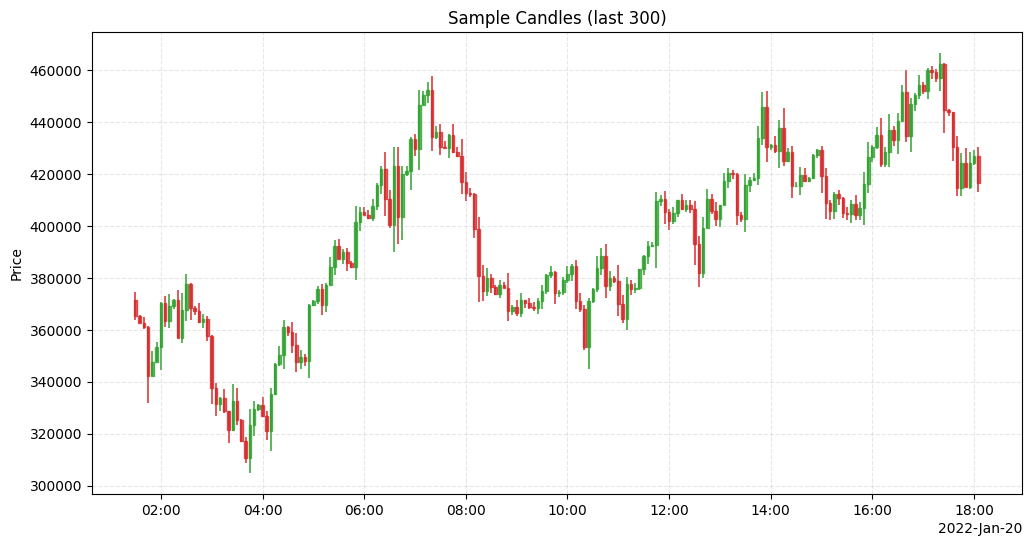

In [2]:
# JUPYTER CELL — Stage 2: Plot candles (line: high↔low, rectangle: open↔close)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_candles(
    df: pd.DataFrame,
    title: str = "Candlestick",
    n_last: int | None = 300,
    body_width: float = 0.6,     # fraction of bar spacing (0..1)
    wick_linewidth: float = 1.2  # wick width in points
):
    """Plot OHLC candles: a vertical line (low-high) and a rectangle (open-close)."""
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    required = {"open","high","low","close"}
    if not required.issubset(g.columns):
        raise ValueError(f"DataFrame must contain {sorted(required)}")

    if n_last is not None and n_last > 0:
        g = g.iloc[-int(n_last):].copy()

    # Convert index to matplotlib date numbers
    x = mdates.date2num(pd.to_datetime(g.index).to_pydatetime())

    # Estimate bar spacing to size bodies
    dx = float(np.median(np.diff(x))) if len(x) > 1 else 1.0
    bw = np.clip(body_width, 0.0, 1.0) * dx

    o = g["open"].to_numpy(float)
    h = g["high"].to_numpy(float)
    l = g["low"].to_numpy(float)
    c = g["close"].to_numpy(float)

    up = c >= o
    dn = ~up
    up_color, dn_color = "#2ca02c", "#d62728"

    fig, ax = plt.subplots(figsize=(12, 6))

    # Wicks (match colors with bodies)
    ax.vlines(x[up], l[up], h[up], linewidth=wick_linewidth, color=up_color, alpha=0.9, zorder=1)
    ax.vlines(x[dn], l[dn], h[dn], linewidth=wick_linewidth, color=dn_color, alpha=0.9, zorder=1)

    # Bodies: bottom=min(open, close), height=abs(close-open)
    body_bottom = np.minimum(o, c)
    body_height = np.abs(c - o)
    ax.bar(x[up], body_height[up], bottom=body_bottom[up], width=bw, align="center",
           edgecolor=up_color, facecolor=up_color, alpha=0.75, zorder=2)
    ax.bar(x[dn], body_height[dn], bottom=body_bottom[dn], width=bw, align="center",
           edgecolor=dn_color, facecolor=dn_color, alpha=0.75, zorder=2)

    # Axis cosmetics
    ax.set_title(title)
    ax.set_ylabel("Price")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.xaxis_date()
    loc = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

    plt.show()

# Quick preview
plot_candles(df, title="Sample Candles (last 300)", n_last=200)


# Features

In [3]:
# JUPYTER CELL — feature: volprof_poc_dist_100 (robust)
FEATURE_CODE = "volprof_poc_dist_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Volume Profile POC distance (100)
    Description:
      Relative distance from the current close to the Point of Control (POC)
      over a 100-bar window; POC via weighted histogram mode (weights=volume).
    Formula / method (brief):
      For each window (size=100):
        - Weighted histogram of close (bins=50 over [min,max]).
        - POC := center of the max-weight bin.
        - dist := (close_t - POC) / close_t
    Input:
      df with columns open, high, low, close, volume (case-insensitive).
    Output:
      pd.Series (float), same index, name == FEATURE_CODE; initial NaNs allowed.
    Constraints:
      - No look-ahead. Uses only current/past data.
      - Numpy/Pandas only (loop over windows; reliable across pandas versions).
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    if not {"close","volume"}.issubset(g.columns):
        raise ValueError("DataFrame must contain 'close' and 'volume'.")

    c = g["close"].to_numpy(float)
    v = g["volume"].to_numpy(float)
    n = len(g); W = 100; BINS = 50

    level = np.full(n, np.nan, float)

    for i in range(W-1, n):
        cs = c[i-W+1:i+1]
        vs = v[i-W+1:i+1]
        m = np.isfinite(cs) & np.isfinite(vs)
        if m.sum() < 3:
            continue
        cs = cs[m]; vs = vs[m]
        pmin, pmax = cs.min(), cs.max()
        if not np.isfinite(pmin) or not np.isfinite(pmax) or pmax <= pmin:
            continue
        hist, edges = np.histogram(cs, bins=BINS, range=(pmin, pmax), weights=vs)
        if hist.size == 0 or np.all(hist <= 0):
            continue
        j = int(np.argmax(hist))
        level[i] = 0.5 * (edges[j] + edges[j+1])

    s = (c - level) / c
    s = pd.Series(s, index=g.index, dtype=float, name=FEATURE_CODE)
    return s


In [4]:
# JUPYTER CELL — feature: volprof_val_dist_100 (robust)
FEATURE_CODE = "volprof_val_dist_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Volume Profile VAL distance (100)
    Description:
      Relative distance from close to Value Area Low (VAL) ≈ weighted 15% quantile
      of close over a 100-bar window (weights=volume).
    Formula / method (brief):
      VAL := weighted_quantile(close, weights=volume, q=0.15)
      dist := (close_t - VAL) / close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    if not {"close","volume"}.issubset(g.columns):
        raise ValueError("DataFrame must contain 'close' and 'volume'.")

    def _wq(px: np.ndarray, w: np.ndarray, q: float) -> float:
        m = np.isfinite(px) & np.isfinite(w) & (w >= 0)
        px = px[m]; w = w[m]
        if px.size < 3 or w.sum() <= 0:
            return np.nan
        order = np.argsort(px)
        px = px[order]; w = w[order]
        csum = np.cumsum(w)
        thr = q * csum[-1]
        i = int(np.searchsorted(csum, thr, side="left"))
        i = min(max(i, 0), len(px)-1)
        return float(px[i])

    c = g["close"].to_numpy(float)
    v = g["volume"].to_numpy(float)
    n = len(g); W = 100

    level = np.full(n, np.nan, float)
    for i in range(W-1, n):
        cs = c[i-W+1:i+1]
        vs = v[i-W+1:i+1]
        level[i] = _wq(cs, vs, 0.15)

    s = (c - level) / c
    s = pd.Series(s, index=g.index, dtype=float, name=FEATURE_CODE)
    return s


In [5]:
# JUPYTER CELL — feature: volprof_vah_dist_100 (robust)
FEATURE_CODE = "volprof_vah_dist_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Volume Profile VAH distance (100)
    Description:
      Relative distance from close to Value Area High (VAH) ≈ weighted 85% quantile
      of close over a 100-bar window (weights=volume).
    Formula / method (brief):
      VAH := weighted_quantile(close, weights=volume, q=0.85)
      dist := (close_t - VAH) / close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    if not {"close","volume"}.issubset(g.columns):
        raise ValueError("DataFrame must contain 'close' and 'volume'.")

    def _wq(px: np.ndarray, w: np.ndarray, q: float) -> float:
        m = np.isfinite(px) & np.isfinite(w) & (w >= 0)
        px = px[m]; w = w[m]
        if px.size < 3 or w.sum() <= 0:
            return np.nan
        order = np.argsort(px)
        px = px[order]; w = w[order]
        csum = np.cumsum(w)
        thr = q * csum[-1]
        i = int(np.searchsorted(csum, thr, side="left"))
        i = min(max(i, 0), len(px)-1)
        return float(px[i])

    c = g["close"].to_numpy(float)
    v = g["volume"].to_numpy(float)
    n = len(g); W = 100

    level = np.full(n, np.nan, float)
    for i in range(W-1, n):
        cs = c[i-W+1:i+1]
        vs = v[i-W+1:i+1]
        level[i] = _wq(cs, vs, 0.85)

    s = (c - level) / c
    s = pd.Series(s, index=g.index, dtype=float, name=FEATURE_CODE)
    return s


In [6]:
# JUPYTER CELL — feature: range_high_dist_50
FEATURE_CODE = "range_high_dist_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Range High Distance (50)
    Description:
      Relative distance from the current close to the rolling 50-bar highest high.
      Positive values mean close is above the range-high (rare), negative values
      mean close is below the range-high (typical).
    Formula / method (brief):
      RH_t = max(high_{t-49..t})
      dist_t = (close_t - RH_t) / close_t
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, length == len(df),
      name == FEATURE_CODE. Initial NaNs from rolling windows are OK.
    Constraints:
      - No look-ahead (uses only current and past data).
      - Vectorized (rolling max).
      - Uses only numpy and pandas.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]  # normalize

    # Rolling 50-bar highest high (includes current bar)
    rh = g["high"].rolling(50, min_periods=50).max().astype(float)

    # Relative distance from range-high
    s = (g["close"].astype(float) - rh) / g["close"].astype(float)
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s

In [7]:
# JUPYTER CELL — feature: range_low_dist_50
FEATURE_CODE = "range_low_dist_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Range Low Distance (50)
    Description:
      Relative distance from the current close to the rolling 50-bar lowest low.
      Positive values mean close is above the range-low (typical), negative values
      mean close is below the range-low (rare).
    Formula / method (brief):
      RL_t = min(low_{t-49..t})
      dist_t = (close_t - RL_t) / close_t
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, length == len(df),
      name == FEATURE_CODE. Initial NaNs from rolling windows are OK.
    Constraints:
      - No look-ahead (uses only current and past data).
      - Vectorized (rolling min).
      - Uses only numpy and pandas.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]  # normalize

    # Rolling 50-bar lowest low (includes current bar)
    rl = g["low"].rolling(50, min_periods=50).min().astype(float)

    # Relative distance from range-low
    s = (g["close"].astype(float) - rl) / g["close"].astype(float)
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s

In [8]:
# JUPYTER CELL — feature: range_breakout_flag_50
FEATURE_CODE = "range_breakout_flag_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Range Breakout Flag (50)
    Description:
      Discrete flag indicating breakout vs. the previous 50 bars (excluding current):
        +1 if close_t > max(high_{t-50..t-1})  (up-breakout)
        -1 if close_t < min(low_{t-50..t-1})   (down-breakout)
         0 otherwise (inside the prior 50-bar range)
    Formula / method (brief):
      prev_high_t = max(high_{t-50..t-1}) = rolling_max(high, 50) on shifted series
      prev_low_t  = min(low_{t-50..t-1})  = rolling_min(low, 50) on shifted series
      flag_t = 1 if close_t > prev_high_t; -1 if close_t < prev_low_t; else 0
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (int), same index as df.index, length == len(df),
      name == FEATURE_CODE. Initial NaNs from rolling windows are OK (will map to 0).
    Constraints:
      - No look-ahead (uses only current and past data; window excludes current via shift).
      - Vectorized (rolling + numpy where).
      - Uses only numpy and pandas.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]  # normalize

    # Prior window (exclude current) via shift(1)
    prev_high = g["high"].shift(1).rolling(50, min_periods=50).max().astype(float)
    prev_low  = g["low"].shift(1).rolling(50, min_periods=50).min().astype(float)

    c = g["close"].astype(float)

    up_break   = c > prev_high
    down_break = c < prev_low

    # Map to {-1, 0, +1}; NaNs in prev_* yield False in comparisons -> 0
    flag = np.where(up_break, 1, np.where(down_break, -1, 0)).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s

In [9]:
# JUPYTER CELL — feature: channel_reg_upper_dist_50
FEATURE_CODE = "channel_reg_upper_dist_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Regression Channel — Upper Distance (50)
    Description:
      Relative distance from the current close to the UPPER regression channel line
      built on a 50-bar rolling linear regression of close vs. time. The channel
      uses the regression line ± 1×(residual_std). Here residual_std is approximated
      by sqrt( var_y * (1 - r^2) ), where r is the rolling correlation between time and close.
      (You can change the multiplier if you want wider/narrower channels.)
    Formula / method (brief):
      For each window W=50:
        - t = 0..N-1 (global index as float); y = close
        - slope = cov(t,y)/var(t)
          with cov, var computed via rolling means (no apply/loops).
        - intercept = mean(y) - slope*mean(t)
        - reg_line_t = slope * t + intercept
        - resid_std ≈ sqrt( var_y * (1 - r^2) ), r = cov / sqrt(var_t*var_y)
        - upper = reg_line_t + 1 * resid_std
        - dist = (close - upper) / close
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, name == FEATURE_CODE.
      Initial NaNs from rolling windows are OK.
    Constraints:
      - No look-ahead.
      - Vectorized with rolling means.
      - Numpy & pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    y = g["close"].astype(float)
    n = len(g)
    W = 50

    # time index as float (global positions 0..n-1)
    t = pd.Series(np.arange(n, dtype=float), index=g.index)

    # rolling means
    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    ty_mean = (t * y).rolling(W, min_periods=W).mean()
    t2_mean = (t * t).rolling(W, min_periods=W).mean()
    y2_mean = (y * y).rolling(W, min_periods=W).mean()

    cov_ty = ty_mean - t_mean * y_mean
    var_t  = t2_mean - t_mean * t_mean
    var_y  = y2_mean - y_mean * y_mean

    slope = cov_ty / var_t.replace(0.0, np.nan)
    intercept = y_mean - slope * t_mean
    reg_line = slope * t + intercept

    # correlation r and residual std ≈ sqrt(var_y * (1 - r^2))
    r = cov_ty / (np.sqrt(var_t) * np.sqrt(var_y))
    resid_std = np.sqrt(np.clip(var_y * (1.0 - r * r), a_min=0.0, a_max=None))

    # channel upper with multiplier m=1.0 (change if desired)
    m = 1.0
    upper = reg_line + m * resid_std

    s = (y - upper) / y
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s

In [10]:
# JUPYTER CELL — feature: channel_reg_lower_dist_50
FEATURE_CODE = "channel_reg_lower_dist_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Regression Channel — Lower Distance (50)
    Description:
      Relative distance from the current close to the LOWER regression channel line
      built on a 50-bar rolling linear regression of close vs. time. The channel
      uses the regression line ± 1×(residual_std), where residual_std ≈ sqrt(var_y*(1 - r^2)).
    Formula / method (brief):
      Same as the upper version, but:
        lower = reg_line_t - 1 * resid_std
        dist = (close - lower) / close
    Input/Output/Constraints:
      Same as channel_reg_upper_dist_50.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    y = g["close"].astype(float)
    n = len(g)
    W = 50

    t = pd.Series(np.arange(n, dtype=float), index=g.index)

    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    ty_mean = (t * y).rolling(W, min_periods=W).mean()
    t2_mean = (t * t).rolling(W, min_periods=W).mean()
    y2_mean = (y * y).rolling(W, min_periods=W).mean()

    cov_ty = ty_mean - t_mean * y_mean
    var_t  = t2_mean - t_mean * t_mean
    var_y  = y2_mean - y_mean * y_mean

    slope = cov_ty / var_t.replace(0.0, np.nan)
    intercept = y_mean - slope * t_mean
    reg_line = slope * t + intercept

    r = cov_ty / (np.sqrt(var_t) * np.sqrt(var_y))
    resid_std = np.sqrt(np.clip(var_y * (1.0 - r * r), a_min=0.0, a_max=None))

    m = 1.0
    lower = reg_line - m * resid_std

    s = (y - lower) / y
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s


In [11]:
# JUPYTER CELL — feature: trendline_touch_flag_100
FEATURE_CODE = "trendline_touch_flag_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Trendline Touch Flag (100)
    Description:
      Binary flag indicating whether the current close is "touching" the rolling
      regression trendline (close vs. time) over a 100-bar window, within a tolerance
      proportional to the window's residual standard deviation.
    Formula / method (brief):
      For each window W=100:
        - Compute slope/intercept of OLS(y~t); reg_line_t = slope*t + intercept
        - resid = close - reg_line_t
        - resid_std ≈ sqrt(var_y * (1 - r^2))
        - flag = 1 if |resid| <= tol_mult * resid_std  else 0
      Here tol_mult = 0.25 (change if you prefer).
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (int), values in {0,1}, same index as df.index, name == FEATURE_CODE.
    Constraints:
      - No look-ahead; vectorized with rolling means.
      - Numpy & pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    y = g["close"].astype(float)
    n = len(g)
    W = 100
    tol_mult = 0.25

    t = pd.Series(np.arange(n, dtype=float), index=g.index)

    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    ty_mean = (t * y).rolling(W, min_periods=W).mean()
    t2_mean = (t * t).rolling(W, min_periods=W).mean()
    y2_mean = (y * y).rolling(W, min_periods=W).mean()

    cov_ty = ty_mean - t_mean * y_mean
    var_t  = t2_mean - t_mean * t_mean
    var_y  = y2_mean - y_mean * y_mean

    slope = cov_ty / var_t.replace(0.0, np.nan)
    intercept = y_mean - slope * t_mean
    reg_line = slope * t + intercept

    # residual & residual std
    resid = y - reg_line
    r = cov_ty / (np.sqrt(var_t) * np.sqrt(var_y))
    resid_std = np.sqrt(np.clip(var_y * (1.0 - r * r), a_min=0.0, a_max=None))

    flag = (resid.abs() <= (tol_mult * resid_std)).astype(int)
    flag.name = FEATURE_CODE
    return flag


In [12]:
# JUPYTER CELL — feature: trendline_slope_100
FEATURE_CODE = "trendline_slope_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Trendline Slope (100)
    Description:
      Rolling OLS slope of close vs. time over a 100-bar window. This is the same
      idea as reg_lin_slope_W, but with W=100; it measures the per-bar trend
      (positive uptrend, negative downtrend).
    Formula / method (brief):
      slope_t = cov(t,y) / var(t), where cov/var computed via rolling means.
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, name == FEATURE_CODE.
    Constraints:
      - No look-ahead; vectorized with rolling means.
      - Numpy & pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    y = g["close"].astype(float)
    n = len(g)
    W = 100

    t = pd.Series(np.arange(n, dtype=float), index=g.index)

    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    cov = (t * y).rolling(W, min_periods=W).mean() - t_mean * y_mean
    var = (t * t).rolling(W, min_periods=W).mean() - t_mean * t_mean

    slope = cov / var.replace(0.0, np.nan)
    slope = slope.astype(float)
    slope.name = FEATURE_CODE
    return slope


In [13]:
# JUPYTER CELL — feature: pivot_classic_pp_dist_1d
FEATURE_CODE = "pivot_classic_pp_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot Point distance (previous day)
    Description:
      Relative distance from the current close to the prior day's Classic Pivot Point (PP).
      PP_prev_day = (H_prev + L_prev + C_prev) / 3, computed from the previous trading day.
    Formula / method (brief):
      - Aggregate intraday into daily H/L/C via groupby(normalized date).
      - Shift by 1 day to avoid look-ahead.
      - PP = (H_prev + L_prev + C_prev)/3
      - dist = (close_t - PP_for_today)/close_t
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, name == FEATURE_CODE.
      First day(s) will be NaN (no prior day).
    Constraints:
      - No look-ahead (uses prior day levels only).
      - Vectorized (groupby + map).
      - Uses numpy and pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]  # normalize
    days = g.index.normalize()

    # Daily OHLC (based on intraday)
    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )

    # Previous-day pivots
    daily_prev = daily.shift(1)
    pp_daily = (daily_prev["high"] + daily_prev["low"] + daily_prev["close"]) / 3.0

    # Map each intraday bar's day -> that day's PP (from previous day)
    pp_intraday = pd.Series(pd.Index(days).map(pp_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - pp_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s

In [14]:
# JUPYTER CELL — feature: pivot_classic_r1_dist_1d
FEATURE_CODE = "pivot_classic_r1_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot R1 distance (previous day)
    Description:
      Relative distance from close to prior day's Classic R1.
      R1_prev = 2*PP_prev - L_prev, where PP_prev = (H_prev+L_prev+C_prev)/3.
    Formula / method (brief):
      - Daily OHLC from intraday; shift by 1 to get prior day.
      - Compute PP_prev, then R1_prev.
      - dist = (close_t - R1_today)/close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    days = g.index.normalize()

    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )
    dprev = daily.shift(1)
    pp = (dprev["high"] + dprev["low"] + dprev["close"]) / 3.0
    r1_daily = 2.0 * pp - dprev["low"]

    r1_intraday = pd.Series(pd.Index(days).map(r1_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - r1_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s


In [15]:
# JUPYTER CELL — feature: pivot_classic_r2_dist_1d
FEATURE_CODE = "pivot_classic_r2_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot R2 distance (previous day)
    Description:
      Relative distance from close to prior day's Classic R2.
      R2_prev = PP_prev + (H_prev - L_prev), where PP_prev = (H_prev+L_prev+C_prev)/3.
    Formula / method (brief):
      - Daily OHLC from intraday; shift by 1.
      - Compute PP_prev, then R2_prev.
      - dist = (close_t - R2_today)/close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    days = g.index.normalize()

    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )
    dprev = daily.shift(1)
    pp = (dprev["high"] + dprev["low"] + dprev["close"]) / 3.0
    r2_daily = pp + (dprev["high"] - dprev["low"])

    r2_intraday = pd.Series(pd.Index(days).map(r2_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - r2_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s


In [16]:
# JUPYTER CELL — feature: pivot_classic_s1_dist_1d
FEATURE_CODE = "pivot_classic_s1_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot S1 distance (previous day)
    Description:
      Relative distance from close to prior day's Classic S1.
      S1_prev = 2*PP_prev - H_prev, where PP_prev = (H_prev+L_prev+C_prev)/3.
    Formula / method (brief):
      - Daily OHLC from intraday; shift by 1.
      - Compute PP_prev, then S1_prev.
      - dist = (close_t - S1_today)/close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    days = g.index.normalize()

    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )
    dprev = daily.shift(1)
    pp = (dprev["high"] + dprev["low"] + dprev["close"]) / 3.0
    s1_daily = 2.0 * pp - dprev["high"]

    s1_intraday = pd.Series(pd.Index(days).map(s1_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - s1_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s


In [17]:
# JUPYTER CELL — feature: pivot_classic_s2_dist_1d
FEATURE_CODE = "pivot_classic_s2_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot S2 distance (previous day)
    Description:
      Relative distance from close to prior day's Classic S2.
      S2_prev = PP_prev - (H_prev - L_prev), where PP_prev = (H_prev+L_prev+C_prev)/3.
    Formula / method (brief):
      - Daily OHLC from intraday; shift by 1.
      - Compute PP_prev, then S2_prev.
      - dist = (close_t - S2_today)/close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    days = g.index.normalize()

    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )
    dprev = daily.shift(1)
    pp = (dprev["high"] + dprev["low"] + dprev["close"]) / 3.0
    s2_daily = pp - (dprev["high"] - dprev["low"])

    s2_intraday = pd.Series(pd.Index(days).map(s2_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - s2_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s


In [18]:
# JUPYTER CELL — feature: mom_rsi_div_flag_14_5
FEATURE_CODE = "mom_rsi_div_flag_14_5"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    RSI Divergence Flag (RSI-14, lookback 5)
    Description:
      Flags simple bullish/bearish divergences between price and RSI:
        +1 (bullish): price makes a lower low vs prior 5 bars while RSI does NOT make a lower low.
        -1 (bearish): price makes a higher high vs prior 5 bars while RSI does NOT make a higher high.
         0 otherwise.
      (This is a lightweight, vectorized approximation of swing-based divergences.)
    Formula / method (brief, cite if needed):
      - RSI(14) via Wilder smoothing:
          gain = max(diff(close), 0), loss = max(-diff(close), 0)
          avg_gain = ewm(gain, alpha=1/14), avg_loss = ewm(loss, alpha=1/14)
          RS = avg_gain/avg_loss; RSI = 100 - 100/(1+RS)
      - With lookback L=5:
          prev_high  = rolling_max(close.shift(1), L)
          prev_low   = rolling_min(close.shift(1), L)
          prev_rsi_hi = rolling_max(RSI.shift(1), L)
          prev_rsi_lo = rolling_min(RSI.shift(1), L)
        bearish_div = (close > prev_high) & (RSI <= prev_rsi_hi - eps)
        bullish_div = (close < prev_low)  & (RSI >= prev_rsi_lo + eps)
      - flag = +1 if bullish_div, -1 if bearish_div, else 0
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (int), values in {-1,0,+1}, same index as df.index, name == FEATURE_CODE.
      Initial NaNs from rolling windows are OK (mapped to 0 by comparisons).
    Constraints:
      - No look-ahead (all comparisons use shifted/rolling past data).
      - Vectorized; numpy and pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    close = g["close"].astype(float)
    delta = close.diff()

    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    alpha = 1.0 / 14.0
    avg_gain = gain.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    avg_loss = loss.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    rs = avg_gain / avg_loss.replace(0.0, np.nan)
    rsi = 100.0 - 100.0 / (1.0 + rs)
    rsi = rsi.clip(0.0, 100.0)

    L = 5
    prev_high   = g["close"].shift(1).rolling(L, min_periods=L).max()
    prev_low    = g["close"].shift(1).rolling(L, min_periods=L).min()
    prev_rsi_hi = rsi.shift(1).rolling(L, min_periods=L).max()
    prev_rsi_lo = rsi.shift(1).rolling(L, min_periods=L).min()

    eps = 0.1  # tiny tolerance
    bearish = (close > prev_high) & (rsi <= (prev_rsi_hi - eps))
    bullish = (close < prev_low)  & (rsi >= (prev_rsi_lo + eps))

    flag = np.where(bullish, 1, np.where(bearish, -1, 0)).astype(int)
    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [19]:
# JUPYTER CELL — feature: trend_sma_cross_flag_5_20
FEATURE_CODE = "trend_sma_cross_flag_5_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    SMA Crossover Flag (5 vs 20)
    Description:
      Discrete flag for moving-average crossovers:
        +1 when SMA(5) crosses ABOVE SMA(20) at current bar,
        -1 when SMA(5) crosses BELOW SMA(20) at current bar,
         0 otherwise.
    Formula / method (brief):
      s5  = SMA(close, 5), s20 = SMA(close, 20)
      d   = s5 - s20
      cross_up   if d>0 and d.shift(1)<=0
      cross_down if d<0 and d.shift(1)>=0
      flag = +1/-1/0
    Input / Output / Constraints:
      As per base structure; vectorized; no look-ahead.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    s5  = g["close"].rolling(5,  min_periods=5).mean()
    s20 = g["close"].rolling(20, min_periods=20).mean()
    d = s5 - s20

    cross_up   = (d > 0) & (d.shift(1) <= 0)
    cross_down = (d < 0) & (d.shift(1) >= 0)

    flag = np.where(cross_up, 1, np.where(cross_down, -1, 0)).astype(int)
    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [20]:
# JUPYTER CELL — feature: ichimoku_tenkan_dist_9
FEATURE_CODE = "ichimoku_tenkan_dist_9"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Tenkan Distance (9)
    Description:
      Relative distance from close to Tenkan-sen over 9 bars.
      Tenkan(9) = (rolling_high_9 + rolling_low_9) / 2.
    Formula / method (brief):
      hi9 = rolling max(high, 9); lo9 = rolling min(low, 9)
      tenkan = (hi9 + lo9)/2
      dist = (close - tenkan)/close
    Input/Output/Constraints:
      Standard; no look-ahead; vectorized.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi9 = g["high"].rolling(9, min_periods=9).max()
    lo9 = g["low"].rolling(9, min_periods=9).min()
    tenkan = (hi9 + lo9) / 2.0

    s = (g["close"].astype(float) - tenkan) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [21]:
# JUPYTER CELL — feature: ichimoku_kijun_dist_26
FEATURE_CODE = "ichimoku_kijun_dist_26"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Kijun Distance (26)
    Description:
      Relative distance from close to Kijun-sen over 26 bars.
      Kijun(26) = (rolling_high_26 + rolling_low_26) / 2.
    Formula:
      hi26 = rolling max(high,26); lo26 = rolling min(low,26)
      kijun = (hi26 + lo26)/2
      dist = (close - kijun)/close
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi26 = g["high"].rolling(26, min_periods=26).max()
    lo26 = g["low"].rolling(26, min_periods=26).min()
    kijun = (hi26 + lo26) / 2.0

    s = (g["close"].astype(float) - kijun) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [22]:
# JUPYTER CELL — feature: ichimoku_span_a_dist_52
FEATURE_CODE = "ichimoku_span_a_dist_52"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Senkou Span A Distance (lag-aligned)
    Description:
      Relative distance from close to Senkou Span A, aligned to current bar without look-ahead.
      Standard Span A is (Tenkan+Kijun)/2 shifted 26 bars forward. To avoid look-ahead,
      we use the unshifted value (equivalently, the standard Span A shifted BACK by 26),
      which depends only on past data.
    Formula / method (brief):
      tenkan = (max(high,9) + min(low,9))/2
      kijun  = (max(high,26)+ min(low,26))/2
      spanA_unshifted = (tenkan + kijun)/2
      dist = (close - spanA_unshifted)/close
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi9  = g["high"].rolling(9,  min_periods=9 ).max()
    lo9  = g["low"] .rolling(9,  min_periods=9 ).min()
    tenk = (hi9 + lo9) / 2.0

    hi26 = g["high"].rolling(26, min_periods=26).max()
    lo26 = g["low"] .rolling(26, min_periods=26).min()
    kij  = (hi26 + lo26) / 2.0

    span_a = (tenk + kij) / 2.0  # lag-aligned (no forward shift)
    s = (g["close"].astype(float) - span_a) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [23]:
# JUPYTER CELL — feature: ichimoku_span_b_dist_52
FEATURE_CODE = "ichimoku_span_b_dist_52"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Senkou Span B Distance (lag-aligned, 52)
    Description:
      Relative distance from close to Senkou Span B over 52 bars, aligned to current bar
      without look-ahead. Standard Span B = (max(high,52)+min(low,52))/2 shifted 26 forward;
      here we use the unshifted value (equivalently, standard Span B shifted BACK 26),
      which uses only past data at each row.
    Formula:
      hi52 = rolling max(high,52); lo52 = rolling min(low,52)
      spanB_unshifted = (hi52 + lo52)/2
      dist = (close - spanB_unshifted)/close
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi52 = g["high"].rolling(52, min_periods=52).max()
    lo52 = g["low"] .rolling(52, min_periods=52).min()
    span_b = (hi52 + lo52) / 2.0

    s = (g["close"].astype(float) - span_b) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [24]:
# JUPYTER CELL — feature: ichimoku_cloud_thickness_52
FEATURE_CODE = "ichimoku_cloud_thickness_52"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Cloud Thickness (lag-aligned, 52)
    Description:
      Normalized thickness of the Ichimoku cloud at the current bar (no look-ahead),
      defined as |SpanA - SpanB| / close. Both spans are the lag-aligned versions:
        SpanA = (Tenkan + Kijun)/2  (unshifted)
        SpanB = (max(high,52) + min(low,52))/2  (unshifted)
    Formula:
      tenkan(9), kijun(26), spanA=(tenkan+kijun)/2; spanB=(hi52+lo52)/2
      thickness = abs(spanA - spanB)/close
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi9  = g["high"].rolling(9,  min_periods=9 ).max()
    lo9  = g["low"] .rolling(9,  min_periods=9 ).min()
    tenk = (hi9 + lo9) / 2.0

    hi26 = g["high"].rolling(26, min_periods=26).max()
    lo26 = g["low"] .rolling(26, min_periods=26).min()
    kij  = (hi26 + lo26) / 2.0

    span_a = (tenk + kij) / 2.0
    hi52 = g["high"].rolling(52, min_periods=52).max()
    lo52 = g["low"] .rolling(52, min_periods=52).min()
    span_b = (hi52 + lo52) / 2.0

    thickness = (span_a - span_b).abs() / g["close"].astype(float)
    thickness = thickness.astype(float)
    thickness.name = FEATURE_CODE
    return thickness


In [25]:
# JUPYTER CELL — feature: band_gauss_upper_dist_20_2
FEATURE_CODE = "band_gauss_upper_dist_20_2"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Gaussian/Bollinger Upper Band Distance (20, 2σ)
    Description:
      Relative distance from close to the upper Gaussian band:
        upper = SMA(close,20) + 2 * std(close,20, ddof=0)
      (This is the common Bollinger upper band with 20 periods, 2 standard deviations.)
    Formula / method (brief):
      ma20 = rolling mean(close,20); sd20 = rolling std(close,20) with ddof=0
      upper = ma20 + 2*sd20
      dist = (close - upper)/close
    Input/Output/Constraints:
      Standard; vectorized; no look-ahead.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    ma20 = g["close"].rolling(20, min_periods=20).mean()
    sd20 = g["close"].rolling(20, min_periods=20).std(ddof=0)  # population std
    upper = ma20 + 2.0 * sd20

    s = (g["close"].astype(float) - upper) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [26]:
# JUPYTER CELL — feature: regime_range_flag_adx_14
FEATURE_CODE = "regime_range_flag_adx_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Range Flag via ADX (14)
    Description:
      Flags 1 when ADX(14) < 20 (weak trend), suggesting a ranging/sideways regime. Else 0.
    Method:
      Same ADX pipeline as above; only final condition changes to (ADX < 20).
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)

    up_move   = h.diff()
    down_move = -l.diff()

    plus_dm  = np.where((up_move > down_move) & (up_move > 0),  up_move,  0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=g.index)
    minus_dm = pd.Series(minus_dm, index=g.index)

    tr = pd.concat([(h - l), (h - c.shift(1)).abs(), (l - c.shift(1)).abs()], axis=1).max(axis=1)

    alpha = 1/14
    tr_sm     = tr.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    plus_sm   = plus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    minus_sm  = minus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    plus_di  = 100.0 * (plus_sm  / tr_sm.replace(0.0, np.nan))
    minus_di = 100.0 * (minus_sm / tr_sm.replace(0.0, np.nan))

    dx = 100.0 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0.0, np.nan)
    adx = dx.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    flag = (adx < 20.0).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [27]:
# JUPYTER CELL — feature: regime_trend_down_flag_adx_14
FEATURE_CODE = "regime_trend_down_flag_adx_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Downtrend Flag via ADX (14)
    Description:
      Flags 1 when ADX(14) >= 20 and -DI > +DI (trend strength + negative direction). Else 0.
    Method:
      Same ADX pipeline as the uptrend version, final condition reversed.
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)

    up_move   = h.diff()
    down_move = -l.diff()

    plus_dm  = np.where((up_move > down_move) & (up_move > 0),  up_move,  0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=g.index)
    minus_dm = pd.Series(minus_dm, index=g.index)

    tr = pd.concat([(h - l), (h - c.shift(1)).abs(), (l - c.shift(1)).abs()], axis=1).max(axis=1)

    alpha = 1/14
    tr_sm     = tr.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    plus_sm   = plus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    minus_sm  = minus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    plus_di  = 100.0 * (plus_sm  / tr_sm.replace(0.0, np.nan))
    minus_di = 100.0 * (minus_sm / tr_sm.replace(0.0, np.nan))

    dx = 100.0 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0.0, np.nan)
    adx = dx.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    flag = ((adx >= 20.0) & (minus_di > plus_di)).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [28]:
# JUPYTER CELL — feature: regime_trend_up_flag_adx_14
FEATURE_CODE = "regime_trend_up_flag_adx_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Uptrend Flag via ADX (14)
    Description:
      Flags 1 when ADX(14) >= 20 and +DI > -DI (trend strength + positive direction). Else 0.
    Method (Wilder approximations using EWM as proxy):
      +DM = max(high_t - high_{t-1}, 0) if > (low_{t-1} - low_t) else 0
      -DM = max(low_{t-1} - low_t, 0)  if > (high_t - high_{t-1}) else 0
      TR  = max(high-low, |high-close_{t-1}|, |low-close_{t-1}|)
      Smooth with EWM(alpha=1/14, adjust=False, min_periods=14)
      +DI = 100 * (+DM_sm / TR_sm); -DI = 100 * (-DM_sm / TR_sm)
      DX  = 100 * |(+DI - -DI)| / (+DI + -DI)
      ADX = EWM(DX, alpha=1/14, adjust=False, min_periods=14)
      flag = 1 if (ADX>=20) & (+DI > -DI) else 0
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)

    up_move   = h.diff()
    down_move = -l.diff()

    plus_dm  = np.where((up_move > down_move) & (up_move > 0),  up_move,  0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=g.index)
    minus_dm = pd.Series(minus_dm, index=g.index)

    tr = pd.concat([(h - l), (h - c.shift(1)).abs(), (l - c.shift(1)).abs()], axis=1).max(axis=1)

    alpha = 1/14
    tr_sm     = tr.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    plus_sm   = plus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    minus_sm  = minus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    plus_di  = 100.0 * (plus_sm  / tr_sm.replace(0.0, np.nan))
    minus_di = 100.0 * (minus_sm / tr_sm.replace(0.0, np.nan))

    dx = 100.0 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0.0, np.nan)
    adx = dx.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    flag = ((adx >= 20.0) & (plus_di > minus_di)).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [29]:
# JUPYTER CELL — feature: regime_trend_down_flag_slopeatr_50_14
FEATURE_CODE = "regime_trend_down_flag_slope_50_atr_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Downtrend Flag via Regression Slope normalized by ATR (W=50, ATR=14)
    Description:
      Flags 1 when rolling OLS slope(close~time,50) normalized by ATR(14) is below −k (k=0.05),
      implying a persistent downward drift vs. volatility. Else 0.
    Method:
      Same slope/ATR as the uptrend version.
      z = slope50 / atr14
      flag = 1 if z <= -k else 0
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    y = g["close"].astype(float)
    n = len(g); W = 50

    t = pd.Series(np.arange(n, dtype=float), index=g.index)
    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    cov = (t*y).rolling(W, min_periods=W).mean() - t_mean*y_mean
    var = (t*t).rolling(W, min_periods=W).mean() - t_mean*t_mean
    slope = cov / var.replace(0.0, np.nan)

    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)
    tr = pd.concat([
        (h - l),
        (h - c.shift(1)).abs(),
        (l - c.shift(1)).abs()
    ], axis=1).max(axis=1)
    atr14 = tr.ewm(alpha=1/14, adjust=False, min_periods=14).mean()

    z = slope / atr14.replace(0.0, np.nan)
    k = 0.05
    flag = (z <= -k).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [30]:
# JUPYTER CELL — feature: regime_trend_up_flag_slopeatr_50_14
FEATURE_CODE = "regime_trend_up_flag_slope_50_atr_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Uptrend Flag via Regression Slope normalized by ATR (W=50, ATR=14)
    Description:
      Flags 1 when rolling OLS slope(close~time,50) normalized by ATR(14) is above +k (k=0.05 by default),
      implying a persistent upward drift vs. recent volatility. Else 0.
    Method:
      slope50 = cov(t,y)/var(t) using rolling means (y=close, t=0..N-1)
      atr14 = Wilder ATR(14) on high/low/close
      z = slope50 / atr14
      flag = 1 if z >= k else 0   (k = 0.05)
    Notes:
      - Units: slope is price/bar; dividing by ATR (price units) yields per-bar in ATR units.
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    y = g["close"].astype(float)
    n = len(g); W = 50

    # Rolling OLS slope
    t = pd.Series(np.arange(n, dtype=float), index=g.index)
    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    cov = (t*y).rolling(W, min_periods=W).mean() - t_mean*y_mean
    var = (t*t).rolling(W, min_periods=W).mean() - t_mean*t_mean
    slope = cov / var.replace(0.0, np.nan)

    # ATR(14) — Wilder
    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)
    tr = pd.concat([
        (h - l),
        (h - c.shift(1)).abs(),
        (l - c.shift(1)).abs()
    ], axis=1).max(axis=1)
    atr14 = tr.ewm(alpha=1/14, adjust=False, min_periods=14).mean()

    z = slope / atr14.replace(0.0, np.nan)
    k = 0.05
    flag = (z >= k).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [31]:
# JUPYTER CELL — feature: regime_range_flag_bb_20_q20
FEATURE_CODE = "regime_range_flag_bb_20_q20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Range Flag via Bollinger Bandwidth (BB(20), below 20th percentile over 120 bars)
    Description:
      Flags 1 when the 20-bar Bollinger Bandwidth is unusually low (<= rolling 20% quantile over 120 bars),
      which often corresponds to ranging/sideways regimes. Otherwise 0.
    Method:
      ma20 = SMA(close,20); sd20 = STD(close,20, ddof=0)
      bbw20 = (upper - lower) / ma20 = (2*sd20 + 2*sd20) / ma20 = 4*sd20/ma20
      thresh = rolling_quantile(bbw20, window=120, q=0.20) (using pandas.Series.quantile on rolling)
      flag = 1 if bbw20 <= thresh else 0
    Constraints:
      - No look-ahead (threshold is from rolling past+current window).
      - Vectorized; numpy & pandas only.
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    c = g["close"].astype(float)

    ma20 = c.rolling(20, min_periods=20).mean()
    sd20 = c.rolling(20, min_periods=20).std(ddof=0)
    bbw20 = (4.0 * sd20) / ma20.replace(0.0, np.nan)  # normalized width

    # Rolling 20th percentile over 120 bars
    # Note: rolling(...).quantile(q) is vectorized and avoids look-ahead.
    thresh = bbw20.rolling(120, min_periods=120).quantile(0.20, interpolation="linear")

    flag = (bbw20 <= thresh).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [33]:
# JUPYTER CELL — feature: band_gauss_lower_dist_20_2
FEATURE_CODE = "band_gauss_lower_dist_20_2"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Gaussian Lower Band Distance (20, 2σ)
    Description:
      Relative distance from close to the lower Gaussian band:
        lower = SMA(close,20) - 2 * std(close,20, ddof=0)
      (This is the common Bollinger lower band with 20 periods, 2 standard deviations.)
    Formula / method (brief):
      ma20 = rolling mean(close,20); sd20 = rolling std(close,20) with ddof=0
      lower = ma20 - 2 * sd20
      dist = (close - lower) / close
    Input/Output/Constraints:
      Standard; vectorized; no look-ahead.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    ma20 = g["close"].rolling(20, min_periods=20).mean()
    sd20 = g["close"].rolling(20, min_periods=20).std(ddof=0)
    lower = ma20 - 2 * sd20

    s = (g["close"].astype(float) - lower) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [35]:
# JUPYTER CELL — feature: fib_extension_near_1_272
FEATURE_CODE = "fib_extension_near_1_272"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fibonacci Extension Near 1.272
    Description:
      Flags if the close is near the Fibonacci extension level of 1.272.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      fib_1_272 = (high - low) * 1.272 + low
      flag = 1 if abs(close - fib_1_272) / close <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].rolling(2, min_periods=2).max()
    low = g["low"].rolling(2, min_periods=2).min()

    fib_1_272 = (high - low) * 1.272 + low

    epsilon = 0.01  # proximity range, you can adjust this value
    flag = (abs(g["close"] - fib_1_272) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [37]:
# JUPYTER CELL — feature: fib_extension_near_1_618
FEATURE_CODE = "fib_extension_near_1_618"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fibonacci Extension Near 1.618
    Description:
      Flags if the close is near the Fibonacci extension level of 1.618.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      fib_1_618 = (high - low) * 1.618 + low
      flag = 1 if abs(close - fib_1_618) / close <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].rolling(2, min_periods=2).max()
    low = g["low"].rolling(2, min_periods=2).min()

    fib_1_618 = (high - low) * 1.618 + low

    epsilon = 0.01  # proximity range, you can adjust this value
    flag = (abs(g["close"] - fib_1_618) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [41]:
# JUPYTER CELL — feature: fib_retracement_near_0_500
FEATURE_CODE = "fib_retracement_near_0_500"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fibonacci Retracement Near 0.500
    Description:
      Flags if the close is near the Fibonacci retracement level of 50%.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      fib_0_500 = (high - low) * 0.500 + low
      flag = 1 if abs(close - fib_0_500) / close <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].rolling(2, min_periods=2).max()
    low = g["low"].rolling(2, min_periods=2).min()

    fib_0_500 = (high - low) * 0.500 + low

    epsilon = 0.01  # proximity range, you can adjust this value
    flag = (abs(g["close"] - fib_0_500) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [43]:
# JUPYTER CELL — feature: fib_retracement_near_0_618
FEATURE_CODE = "fib_retracement_near_0_618"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fibonacci Retracement Near 0.618
    Description:
      Flags if the close is near the Fibonacci retracement level of 61.8%.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      fib_0_618 = (high - low) * 0.618 + low
      flag = 1 if abs(close - fib_0_618) / close <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].rolling(2, min_periods=2).max()
    low = g["low"].rolling(2, min_periods=2).min()

    fib_0_618 = (high - low) * 0.618 + low

    epsilon = 0.01  # proximity range, you can adjust this value
    flag = (abs(g["close"] - fib_0_618) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [45]:
# JUPYTER CELL — feature: liq_daily_zone_touch_flag_1d
FEATURE_CODE = "liq_daily_zone_touch_flag_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Zone Daily Touch Flag (1d)
    Description:
      Flags 1 if the close touches the liquidity zone (high-low range) of the prior day.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      daily_high = high of previous day
      daily_low = low of previous day
      flag = 1 if close_t is between (daily_low - ε) and (daily_high + ε)
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high_prev = g["high"].shift(1)
    low_prev = g["low"].shift(1)

    epsilon = 0.01  # proximity range
    flag = ((g["close"] >= low_prev - epsilon) & (g["close"] <= high_prev + epsilon)).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [47]:
# JUPYTER CELL — feature: liq_weekly_zone_touch_flag_1w
FEATURE_CODE = "liq_weekly_zone_touch_flag_1w"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Zone Weekly Touch Flag (1w)
    Description:
      Flags 1 if the close touches the liquidity zone (high-low range) of the prior week.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      weekly_high = high of previous week
      weekly_low = low of previous week
      flag = 1 if close_t is between (weekly_low - ε) and (weekly_high + ε)
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high_prev = g["high"].shift(5)  # Assumes 5 trading days per week
    low_prev = g["low"].shift(5)  # Assumes 5 trading days per week

    epsilon = 0.01  # proximity range
    flag = ((g["close"] >= low_prev - epsilon) & (g["close"] <= high_prev + epsilon)).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [49]:
# JUPYTER CELL — feature: liq_zone_strength_50
FEATURE_CODE = "liq_zone_strength_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Zone Strength (50)
    Description:
      Measures the relative liquidity strength (volume density) within a 50-bar window.
      Higher liquidity strength is associated with higher trading volumes within a given range.
    Formula / method (brief):
      - liquidity_strength = sum(volume within range) / (high - low) over the last 50 bars
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"]
    low = g["low"]
    volume = g["volume"]

    liquidity_strength = (volume * (high - low)).rolling(50, min_periods=50).sum() / (high - low).rolling(50, min_periods=50).sum()

    s = liquidity_strength.astype(float)
    s.name = FEATURE_CODE
    return s


In [51]:
# JUPYTER CELL — feature: liq_zone_touch_flag_50
FEATURE_CODE = "liq_zone_touch_flag_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Zone Touch Flag (50)
    Description:
      Flags 1 if the close touches the liquidity zone (high-low range) over the last 50 bars.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      liquidity_zone = high-low for the last 50 bars
      flag = 1 if close_t is within liquidity_zone (+ε) and (-ε)
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"]
    low = g["low"]

    liquidity_zone_high = high.rolling(50, min_periods=50).max()
    liquidity_zone_low = low.rolling(50, min_periods=50).min()

    epsilon = 0.01  # proximity range
    flag = ((g["close"] >= liquidity_zone_low - epsilon) & (g["close"] <= liquidity_zone_high + epsilon)).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [54]:
# JUPYTER CELL — feature: price_prev_high_dist_1
FEATURE_CODE = "price_prev_high_dist_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Price Previous High Distance (1 bar)
    Description:
      Flags 1 if the close is close to the high of the previous bar.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      prev_high = high of previous bar
      flag = 1 if abs(close_t - prev_high) / close_t <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    prev_high = g["high"].shift(1)

    epsilon = 0.01  # proximity range
    flag = (abs(g["close"] - prev_high) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [56]:
# JUPYTER CELL — feature: price_prev_low_dist_1
FEATURE_CODE = "price_prev_low_dist_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Price Previous Low Distance (1 bar)
    Description:
      Flags 1 if the close is close to the low of the previous bar.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      prev_low = low of previous bar
      flag = 1 if abs(close_t - prev_low) / close_t <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    prev_low = g["low"].shift(1)

    epsilon = 0.01  # proximity range
    flag = (abs(g["close"] - prev_low) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [58]:
# JUPYTER CELL — feature: session_asian_high_dist_1d
FEATURE_CODE = "session_asian_high_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Session Asian High Distance (1d)
    Description:
      Flags 1 if the close is close to the high of the previous day's Asian session.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      asian_high = high of previous day's Asian session
      flag = 1 if abs(close_t - asian_high) / close_t <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    # Assuming Asian session high is the high of the first few hours of the day,
    # we'll calculate it from the first 4 hours for this example.
    asian_session = g.between_time('00:00', '04:00')  # Adjust based on Asian session time
    asian_high = asian_session["high"].max()

    flag = (abs(g["close"] - asian_high) / g["close"] <= 0.01).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [60]:
# JUPYTER CELL — feature: session_asian_low_dist_1d
FEATURE_CODE = "session_asian_low_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Session Asian Low Distance (1d)
    Description:
      Flags 1 if the close is close to the low of the previous day's Asian session.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      asian_low = low of previous day's Asian session
      flag = 1 if abs(close_t - asian_low) / close_t <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    # Assuming Asian session low is the low of the first few hours of the day,
    # we'll calculate it from the first 4 hours for this example.
    asian_session = g.between_time('00:00', '04:00')  # Adjust based on Asian session time
    asian_low = asian_session["low"].min()

    flag = (abs(g["close"] - asian_low) / g["close"] <= 0.01).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [62]:
# JUPYTER CELL — feature: mom_volume_trend_div_flag_20
FEATURE_CODE = "mom_volume_trend_div_flag_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Volume and Trend Divergence Flag (20)
    Description:
      Flags if there is a divergence between price trend and volume trend.
      Price goes up/down while volume behaves oppositely, indicating a divergence.
    Formula / method (brief):
      - Calculate rolling mean of close and volume over 20 periods.
      - Flag 1 if price and volume trends diverge (one goes up, the other down).
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    price_rolling_mean = g["close"].rolling(20).mean()
    volume_rolling_mean = g["volume"].rolling(20).mean()

    # Identify divergence
    price_up = g["close"] > price_rolling_mean
    volume_up = g["volume"] > volume_rolling_mean

    divergence = (price_up != volume_up).astype(int)

    s = pd.Series(divergence, index=g.index, name=FEATURE_CODE)
    return s


In [64]:
# JUPYTER CELL — feature: trendline_break_rsi_14
FEATURE_CODE = "trendline_break_rsi_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    RSI Trendline Breakout Flag (14)
    Description:
      Flags 1 if RSI(14) breaks through its trendline, indicating a breakout.
    Formula / method (brief):
      - Calculate the 14-period RSI.
      - Detect trendline breakout (RSI crosses its rolling mean).
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    rsi_14 = g["close"].rolling(14).apply(lambda x: 100 - (100 / (1 + (x.diff().clip(0).mean() / x.diff().clip(None).mean()))))

    rsi_trendline = rsi_14.rolling(14).mean()

    breakout = (rsi_14 > rsi_trendline).astype(int)

    s = pd.Series(breakout, index=g.index, name=FEATURE_CODE)
    return s


In [66]:
# JUPYTER CELL — feature: break_prev_low_flag_1
FEATURE_CODE = "break_prev_low_flag_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Break Previous Low Flag (1 bar)
    Description:
      Flags 1 if the current close is lower than the low of the previous bar, indicating a breakdown.
    Formula / method (brief):
      - Check if close_t < low_{t-1}.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    prev_low = g["low"].shift(1)
    flag = (g["close"] < prev_low).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [68]:
# JUPYTER CELL — feature: break_prev_high_flag_1
FEATURE_CODE = "break_prev_high_flag_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Break Previous High Flag (1 bar)
    Description:
      Flags 1 if the current close is higher than the high of the previous bar, indicating a breakout.
    Formula / method (brief):
      - Check if close_t > high_{t-1}.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    prev_high = g["high"].shift(1)
    flag = (g["close"] > prev_high).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [70]:
# JUPYTER CELL — feature: fvg_creation_flag_1
FEATURE_CODE = "fvg_creation_flag_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fair Value Gap Creation Flag (1 bar)
    Description:
      Flags 1 if a fair value gap (FVG) is created, defined as a large price movement gap.
    Formula / method (brief):
      - A gap is formed when the open price is significantly different from the close price.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    price_gap = abs(g["open"] - g["close"].shift(1))

    # Set threshold for large gap (FVG), e.g., 0.01 or any custom logic
    threshold = 0.01

    fvg_flag = (price_gap > threshold).astype(int)

    s = pd.Series(fvg_flag, index=g.index, name=FEATURE_CODE)
    return s


In [71]:
s = compute_feature(df)
assert isinstance(s, pd.Series)
assert s.name == FEATURE_CODE
assert s.index.equals(df.index)
assert len(s) == len(df)
print("OK:", FEATURE_CODE, len(s))

OK: fvg_creation_flag_1 5000
